In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
import quandl
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import scipy
from numpy.linalg import inv
import math
import statsmodels.api as sm

C:\Users\manaj\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### (a) CMT Data

In [2]:
data = quandl.get("USTREASURY/YIELD", authtoken="")
data = data.drop('1 MO', 1)
df = data.loc['2012-1-2':'2015-12-31']
print('\n',df.head(2), '\n\n',df.tail(2))
df1 = df.diff(periods=1).dropna()
norm = df1 -df1.mean()


             3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  30 YR
Date                                                                     
2012-01-03  0.02  0.06  0.12  0.27   0.4  0.89  1.41   1.97   2.67   2.98
2012-01-04  0.02  0.06  0.12  0.25   0.4  0.89  1.43   2.00   2.71   3.03 

             3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  30 YR
Date                                                                     
2015-12-30  0.21  0.47  0.64  1.08  1.36  1.80  2.14   2.31   2.69   3.04
2015-12-31  0.16  0.49  0.65  1.06  1.31  1.76  2.09   2.27   2.67   3.01


###     

### (b) PCA for sample data
    '''
    Calculation Steps:
    Take time series data as input.
    Calcualte covariance of input data
    calculate eigen values and eigen vectors.
    In PCA largest eigen value explains the largest change in the variance, 
    so re-arrange eignvalues in decending order.
    Calcuate the variance ratio to identify % of total var explained by 1st eigen value.
    
    '''

In [3]:
def PCA_manual(df):
    
    c = df.cov()     
    val, vec = np.linalg.eig(c)
    decor = np.argsort(val)[::-1]
    val, vec = val[decor], vec[:, decor]
    tr = sum(val)
    var_ratio_custom = np.cumsum(np.round(val/tr, decimals=4))
    return val, vec, var_ratio_custom



from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(norm)
f=pca.components_
var_ratio = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print ('% variance explained:\n', var_ratio)


print('\n% variance explained (Manual Fuction):\n',PCA_manual(norm)[2])

% variance explained:
 [ 0.8658  0.943   0.9612  0.9735  0.9811  0.9873  0.9924  0.9954  0.9978
  1.    ]

% variance explained (Manual Fuction):
 [ 0.8658  0.943   0.9612  0.9735  0.9811  0.9873  0.9924  0.9954  0.9978
  1.    ]


### (c) i. & ii. PCA Factor Loadings Plot

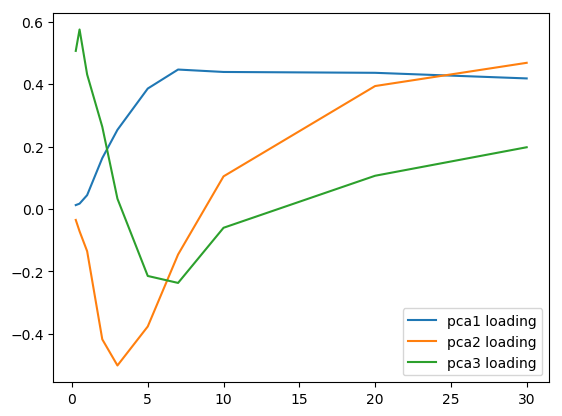

In [4]:
term = [3/12,6/12,1,2,3,5,7,10,20,30] 
plt.plot(term,PCA_manual(norm)[1][:,0],label='pca1 loading')
plt.plot(term,PCA_manual(norm)[1][:,1],label='pca2 loading')
plt.plot(term,PCA_manual(norm)[1][:,2],label='pca3 loading')
plt.legend(loc='lower right') 
plt.show()

### PCA Factors 1, 2 and, 3 Election Day Yield Curve Move Explanation:

In the following section I have used level data and factor loadings to plot yeild curves on dates 2016-11-8 and 2016-11-9.
Transformation is simply the raw data times the factor loadings. The excecise is done for 1st factor, 1st two factors and 1st 
3 factors.

In [5]:
#1st three factor PCA for date : 2016-11-8
x_8 = data.loc['2016-11-8'] - df.mean()
pca1_8 = x_8@PCA_manual(norm)[1][:,0]*PCA_manual(norm)[1][:,0].T
pca1_8 = pca1_8 + df.mean()
pca2_8 =  x_8@PCA_manual(norm)[1][:,1]*PCA_manual(norm)[1][:,1].T
pca12_8 = pca1_8 + pca2_8
pca3_8 =  x_8@PCA_manual(norm)[1][:,2]*PCA_manual(norm)[1][:,2].T
pca13_8 = pca12_8 + pca3_8

#1st three factor PCA for date : 2016-11-9
x_9 = data.loc['2016-11-9'] - df.mean()
pca1_9 = x_9@PCA_manual(norm)[1][:,0]*PCA_manual(norm)[1][:,0].T
pca1_9 = pca1_9 + df.mean()
pca2_9 = x_9@PCA_manual(norm)[1][:,1]*PCA_manual(norm)[1][:,1].T
pca12_9 = pca1_9 + pca2_9
pca3_9 = x_9@PCA_manual(norm)[1][:,2]*PCA_manual(norm)[1][:,2].T
pca13_9 = pca12_9 + pca3_9

diff_fac1 = pca1_9 - pca1_8
diff_fac12 = pca12_9 - pca12_8
diff_fac13 = pca13_9 - pca13_8
diff_raw = x_9 - x_8

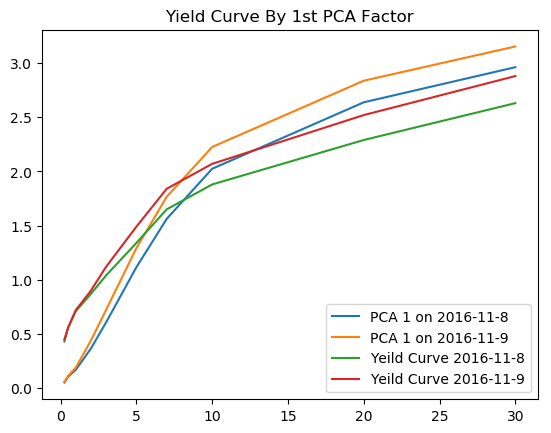

In [6]:
plt.plot(term, pca1_8, label = 'PCA 1 on 2016-11-8')
plt.plot(term, pca1_9, label = 'PCA 1 on 2016-11-9')
plt.plot(term, x_8 + df.mean(), label='Yeild Curve 2016-11-8')
plt.plot(term, x_9 + df.mean(), label='Yeild Curve 2016-11-9')
plt.legend(loc='lower right') 
plt.title('Yield Curve By 1st PCA Factor')
plt.show()

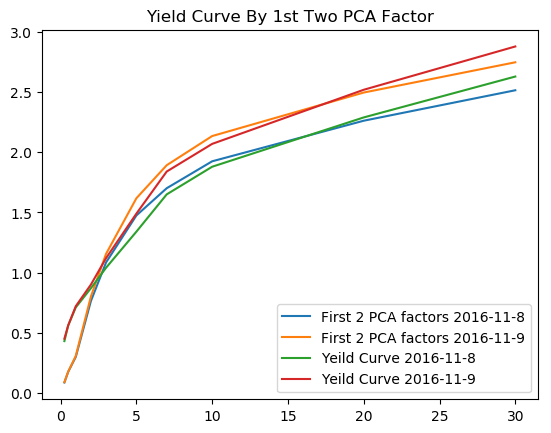

In [7]:
plt.plot(term, pca12_8, label = 'First 2 PCA factors 2016-11-8')
plt.plot(term, pca12_9, label = 'First 2 PCA factors 2016-11-9')
plt.plot(term, x_8 + df.mean(), label='Yeild Curve 2016-11-8')
plt.plot(term, x_9 + df.mean(), label='Yeild Curve 2016-11-9')
plt.legend(loc='lower right')  
plt.title('Yield Curve By 1st Two PCA Factor')
plt.show()

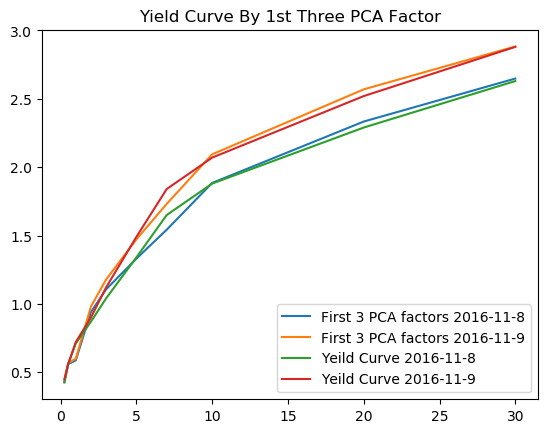

In [8]:
plt.plot(term, pca13_8,label = 'First 3 PCA factors 2016-11-8')
plt.plot(term, pca13_9,label = 'First 3 PCA factors 2016-11-9')
plt.plot(term, x_8 + df.mean(), label='Yeild Curve 2016-11-8')
plt.plot(term, x_9 + df.mean(), label='Yeild Curve 2016-11-9')
plt.legend(loc='lower right')
plt.title('Yield Curve By 1st Three PCA Factor')
plt.show()

### Difference Curves:

For better understanding of the movements explained by PCA, I have plotted the difference explained by different PCA factors Vs the actual shift in yield curve 

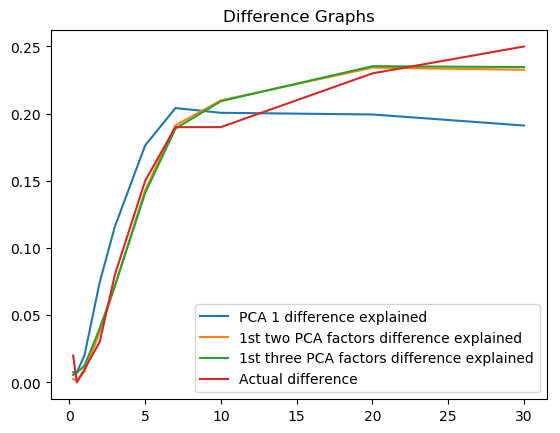

In [9]:
plt.plot(term, diff_fac1, label = 'PCA 1 difference explained')
plt.plot(term, diff_fac12, label = '1st two PCA factors difference explained')
plt.plot(term, diff_fac13, label = '1st three PCA factors difference explained')
plt.plot(term, diff_raw, label = 'Actual difference')
plt.legend(loc='best')
plt.title('Difference Graphs')
plt.show()

### (d): PCA Netural Weights & WFLY1:

In [10]:
#PCA 1 & 2 Factor Neutral Weights 

P_12 = PCA_manual(norm)[1][:,:2]   # P_12 is matrix of 1st two principal components 
coeff = P_12[[5,6,7],:].T         # Exrtacting 1st two principal components for 5, 7 and 10 yrs

'''
From given data we have 3 equations viz. 

w1*PCA1 + w*PCA1 + w2*PCA1 = 0
w1*PCA2 + w*PCA2 + w2*PCA2 = 0
w = -1
Soving these 3 equations for calculating w1 and w2

'''
eq = np.vstack([coeff,[0, 1, 0]]) 
b = np.array([0, 0, -1])
WFLY1_wts = np.linalg.solve(eq,b)
print('PCA Factor 1 & 2 neutral weights are:\n\n[W1_5Yr  W_7Yr  W2_10Yr]:', WFLY1_wts)

PCA Factor 1 & 2 neutral weights are:

[W1_5Yr  W_7Yr  W2_10Yr]: [ 0.5385467  -1.          0.54432553]


In [11]:
WFLY1 = pd.Series(WFLY1_wts[0]*df['5 YR'] + WFLY1_wts[1]*df['7 YR'] + WFLY1_wts[2]*df['10 YR'])
print('Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates:\n\n',WFLY1.head(2),'\n\n', WFLY1.tail(2))

Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates:

 Date
2012-01-03    0.141628
2012-01-04    0.137958
dtype: float64 

 Date
2015-12-30    0.086776
2015-12-31    0.093461
dtype: float64


### (e): i. Box Tiao Implimentation, Mean Reverting Weights, & WFLY2
    '''
    Box Tiao (BT) CCA implementation is based on paper 'Identifying Small Mean 
    Reverting Portfolios' and class notes. 
    
    As per BT CCA the variable and its lag is regressed to find out the coefficents of regression.
    This is implemented in following program using Linear Regression without intercept.
    
    As per paper, the protfolio weights with minimum predictability are given by
    wt = Σ^(-1/2) * z
    Where Z is eigen vector corresponding to smallest eigenvalue of matrix Σ^-1AΣA.T.
    As we are looking for mean-reverting portfolios, we are interested in finding out protfolios with 
    minimum predictability are given by smallest eigen value.
    
    
    '''

In [12]:
def BTCCA(df):

    #Regression with lagged variable Yt = A*Yt-1
    df_t = df[:-1]
    df_lag = df[1:]
    reg = LinearRegression(fit_intercept=False)
    sol = reg.fit(df_t,df_lag)
    A = sol.coef_
    
    #Covariance Matrix & its square-root
    cov = df.cov()
    df_std = scipy.linalg.sqrtm(cov)
    
    #Q=Σ^-1AΣA^T
    Q = inv(np.matrix(cov)) * np.matrix(A) * np.matrix(cov) * np.matrix(A.T)
    
    #Eigen Value with ascending order
    val, vec = np.linalg.eig(Q) 
    ascor = np.argsort(val)
    val, vec = val[ascor], vec[:, ascor]
    
    return val, vec, df_std
    
df_WFLY2 = df[['5 YR', '7 YR', '10 YR']]
df_WFLY2_nm = df_WFLY2 - df_WFLY2.mean()
WFLY2_sol = BTCCA(df_WFLY2_nm) 

WFLY2_x = inv(np.matrix(WFLY2_sol[2])) * np.matrix(WFLY2_sol[1][:,0])
WFLY2_wts = np.array(WFLY2_x/-WFLY2_x[1]).T
WFLY2_wts = WFLY2_wts[0]
print('Box Tiao CCA weights are:\n\n[W1_5Yr  W_7Yr  W2_10Yr]:', WFLY2_wts)

Box Tiao CCA weights are:

[W1_5Yr  W_7Yr  W2_10Yr]: [ 0.66854969 -1.          0.4614276 ]


In [13]:
WFLY2 = pd.Series(WFLY2_wts[0]*df['5 YR'] + WFLY2_wts[1]*df['7 YR'] + WFLY2_wts[2]*df['10 YR'])
print('Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates by Box Taio:\n\n',WFLY2.head(2),'\n\n', WFLY2.tail(2))

Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates by Box Taio:

 Date
2012-01-03    0.094022
2012-01-04    0.087864
dtype: float64 

 Date
2015-12-30    0.129287
2015-12-31    0.134088
dtype: float64


In [14]:
def CCA_Chou_Ng(data_set):
    
    #data_set is pandas dataframe
    df_lag = data_set.shift(1).dropna()
    df = data_set.drop(data_set.index[0]).dropna()
    n = len(data_set.columns)
    
    #X(t) ~ M_1 + X(t-1)
    X = df_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y,X_I).fit()
    B=l1.params[1:(n+1)]
    
    #X(t-1) ~ M_2 + X(t)
    Y_I = sm.add_constant(Y)
    l2 = sm.OLS(X,Y_I).fit()
    A=l2.params[1:(n+1)]
    C = np.dot(A,B)
    eig_val, eig_vec = np.linalg.eig(C)
    return eig_val, eig_vec, C

In [15]:
legs = ['5 YR', '10 YR']
belly = '7 YR'
flylist = [legs[0],belly, legs[1]]
fly=df.ix['2012-01-01':'2015-12-31',flylist]
df1 = fly
n = len(df1.columns)
val, vec, C = CCA_Chou_Ng(df1)
vec = pd.DataFrame(vec)
vec = vec.rename(columns=lambda x: n-x-1, inplace=False)
print (vec)
w = vec[2].values
w_cca_cn = [-w[0]/w[1],-w[2]/w[1]]
print (w_cca_cn)

          2         1         0
0 -0.520278  0.356930 -0.546320
1  0.775538  0.495982  0.757179
2 -0.357563 -0.791583  0.358071
[0.67086059834514034, 0.46105073810723396]


C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [16]:
WFLY2_Ng = pd.Series(w_cca_cn[0]*df['5 YR'] - df['7 YR'] + w_cca_cn[1]*df['10 YR'])
print('Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates by Chou_Ng:\n')
print(WFLY2_Ng.head(2),'\n\n', WFLY2_Ng.tail(2))

Time Series of protfolio yeild on Butterfly with 5, 7, 10 Yrs rates by Chou_Ng:

Date
2012-01-03    0.095336
2012-01-04    0.089167
dtype: float64 

 Date
2015-12-30    0.132576
2015-12-31    0.137300
dtype: float64


### (3) Half-Life and ADF statistics in Sample Test:

In [17]:
def half_life(df):
    mu = df.mean()
    df_t = df[:-1] - mu
    df_lag = df[1:] - mu
    a = np.matrix(df_t) * np.matrix(df_lag).T
    b = np.matrix(df_t) * np.matrix(df_t).T
    l = -math.log(a/b)
    h = math.log(2)/l
    return h


def adf_test(df):
    adf = adfuller(df)
    if adf[0]<=adf[4]['5%']:
        print('\nSince ADF Statistics is less than or euqal to t-statistics at 95% confidence interval.')
        print('Time Series is stationary\n')
    else:
        print('\nSince ADF Statistics is greater than t-statistics at 95% confidence interval.')
        print('Time series is not stationary\n')
    return 'ADF test Statistics are:',adf  

### In sample Stationarity Test WFLY1:

In [18]:
print('The half-life of WFLY1 is:', np.round(half_life(WFLY1),decimals=2))
print( )
print('ADFuller Test for WFLY1 is:')
print(adf_test(WFLY1))

The half-life of WFLY1 is: 36.26

ADFuller Test for WFLY1 is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Time series is not stationary

('ADF test Statistics are:', (-0.76361914660133556, 0.82957583682297098, 13, 987, {'1%': -3.4369927443074353, '5%': -2.8644727567058448, '10%': -2.5683315460972378}, -7024.4430636923526))


### In sample Stationarity Test WFLY2:

In [19]:
print('The half-life of WFLY2 is:', np.round(half_life(WFLY2),decimals=2))
print( )
print('ADFuller Test for WFLY2 is:')
print(adf_test(WFLY2))

The half-life of WFLY2 is: 5.53

ADFuller Test for WFLY2 is:

Since ADF Statistics is less than or euqal to t-statistics at 95% confidence interval.
Time Series is stationary

('ADF test Statistics are:', (-5.6434116279567315, 1.0241981493258331e-06, 2, 998, {'1%': -3.4369193380671001, '5%': -2.8644403834525169, '10%': -2.5683143032357298}, -6882.2822151268692))


##### Since the weight by Chou Ng and Box Taio are aprroximately same I am not repeating the staionarity tests for Chou Ng in the assigenment. This can be visualized by observing following graph.

### Graphical Visualization of mean reversion

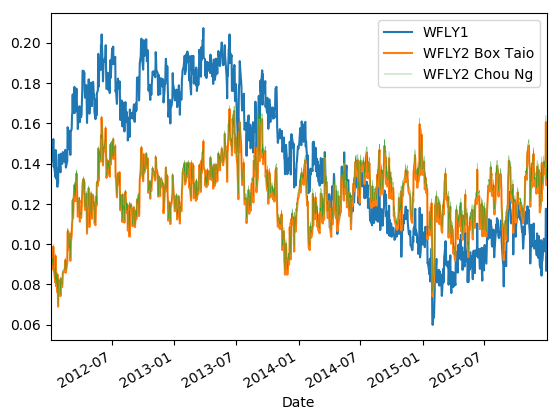

In [20]:
WFLY1.plot(label = 'WFLY1')
WFLY2.plot(label = 'WFLY2 Box Taio')
WFLY2_Ng.plot(label = 'WFLY2 Chou Ng', linewidth= 0.3)
plt.legend()
plt.show()

### (4): Out of sample testing

In [21]:
Three_mo = data.loc['2016-1-1':'2016-3-31']
Six_mo = data.loc['2016-1-1':'2016-6-30']
Twelve_mo = data.loc['2016-1-1':'2016-12-31']

In [22]:
WFLY1_3mo = pd.Series(WFLY1_wts[0]*Three_mo['5 YR'] + WFLY1_wts[1]*Three_mo['7 YR'] + WFLY1_wts[2]*Three_mo['10 YR'])
WFLY1_6mo = pd.Series(WFLY1_wts[0]*Six_mo['5 YR'] + WFLY1_wts[1]*Six_mo['7 YR'] + WFLY1_wts[2]*Six_mo['10 YR'])
WFLY1_12mo = pd.Series(WFLY1_wts[0]*Twelve_mo['5 YR'] + WFLY1_wts[1]*Twelve_mo['7 YR'] + WFLY1_wts[2]*Twelve_mo['10 YR'])

### WFLY1 3, 6, and 12 months out of sample testing:

The half-life of WFLY1 3 months out of sample is: 1.66

ADFuller Test for WFLY1 3 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Time series is not stationary

('ADF test Statistics are:', (-1.609160477493353, 0.47899043909785177, 1, 59, {'1%': -3.5463945337644063, '5%': -2.9119394093846012, '10%': -2.5936515282964665}, -347.5895938492248))



The half-life of WFLY1 6 months out of sample is: 1.66

ADFuller Test for WFLY1 6 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Time series is not stationary

('ADF test Statistics are:', (-2.8450301190131864, 0.052123843935147789, 1, 123, {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}, -791.33717334326388))



The half-life of WFLY1 12 months out of sample is: 8.02

ADFuller Test for WFLY1 12 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Ti

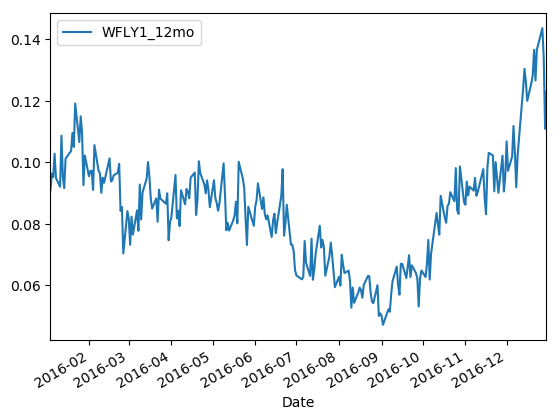

In [23]:
print('The half-life of WFLY1 3 months out of sample is:', np.round(half_life(WFLY1_3mo),decimals=2))
print('\nADFuller Test for WFLY1 3 months out of sample is:')
print(adf_test(WFLY1_3mo))

print('\n\n\nThe half-life of WFLY1 6 months out of sample is:', np.round(half_life(WFLY1_6mo),decimals=2))
print('\nADFuller Test for WFLY1 6 months out of sample is:')
print(adf_test(WFLY1_6mo))

print('\n\n\nThe half-life of WFLY1 12 months out of sample is:', np.round(half_life(WFLY1_12mo),decimals=2))
print('\nADFuller Test for WFLY1 12 months out of sample is:')
print(adf_test(WFLY1_12mo))

WFLY1_12mo.plot(label = 'WFLY1_12mo')
plt.legend()
plt.show()

### WFLY2 3, 6, and 12 months out of sample testing:

In [24]:
WFLY2_3mo = pd.Series(WFLY2_wts[0]*Three_mo['5 YR'] + WFLY2_wts[1]*Three_mo['7 YR'] + WFLY2_wts[2]*Three_mo['10 YR'])
WFLY2_6mo = pd.Series(WFLY2_wts[0]*Six_mo['5 YR'] + WFLY2_wts[1]*Six_mo['7 YR'] + WFLY2_wts[2]*Six_mo['10 YR'])
WFLY2_12mo = pd.Series(WFLY2_wts[0]*Twelve_mo['5 YR'] + WFLY2_wts[1]*Twelve_mo['7 YR'] + WFLY2_wts[2]*Twelve_mo['10 YR'])

The half-life of WFLY2 3 months out of sample is: 2.57

ADFuller Test for WFLY2 3 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Time series is not stationary

('ADF test Statistics are:', (-1.9970142159047455, 0.28788379407428621, 2, 58, {'1%': -3.548493559596539, '5%': -2.9128365947763339, '10%': -2.5941291557669439}, -328.80980314190629))



The half-life of WFLY2 6 months out of sample is: 2.79

ADFuller Test for WFLY2 6 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.
Time series is not stationary

('ADF test Statistics are:', (-2.7314666002647776, 0.068749649001001556, 1, 123, {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}, -759.78354730564024))



The half-life of WFLY2 12 months out of sample is: 15.63

ADFuller Test for WFLY2 12 months out of sample is:

Since ADF Statistics is greater than t-statistics at 95% confidence interval.


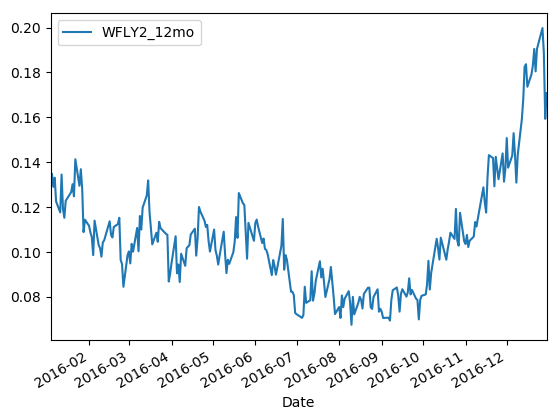

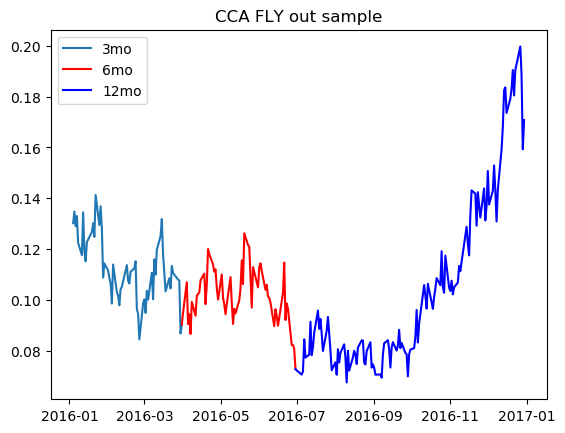

In [26]:
print('The half-life of WFLY2 3 months out of sample is:', np.round(half_life(WFLY2_3mo),decimals=2))
print('\nADFuller Test for WFLY2 3 months out of sample is:')
print(adf_test(WFLY2_3mo))

print('\n\n\nThe half-life of WFLY2 6 months out of sample is:', np.round(half_life(WFLY2_6mo),decimals=2))
print('\nADFuller Test for WFLY2 6 months out of sample is:')
print(adf_test(WFLY2_6mo))

print('\n\n\nThe half-life of WFLY2 12 months out of sample is:', np.round(half_life(WFLY2_12mo),decimals=2))
print('\nADFuller Test for WFLY2 12 months out of sample is:')
print(adf_test(WFLY2_12mo))

WFLY2_12mo.plot(label = 'WFLY2_12mo')
plt.legend()
plt.show()

[plt.plot(WFLY2_3mo),plt.plot(WFLY2_6mo['2016-3-31':'2016-6-30'],'r'),plt.plot(WFLY2_12mo['2016-6-30':'2016-12-31'],'b')]
plt.legend(['3mo','6mo','12mo'])
plt.title('CCA FLY out sample')
plt.show()

### Step Back and Analyze the Results:

Let's analyze why the time series of WFLY1 (In-sample & out-of-sample) and WFLY2 (out-of-sample) are not stationary. I think the change in the monetary policy stance and market perception of Fed's policy action are at the core of the non-stationarity. To mention few points, on December 18, 2013, FOMC announed  tapering back on QE3 at a rate of $ 10 billion at each meeting and in october 2014 Fed ended QE3. On December 2015, Fed hiked FFR interest rate first time since 2006. As we can see the sample we have chosen for analysis was full of action on Monetary Policy front. Also, there was lot of uncertainity in 2016 about impending US presidential election. I believe all these factors affected the stationarity of time series. 
While WFLY2 is stationary in-sample. So, we can say CCA by Box-Taio does a good job as a method of identifying mean reverting portfolio at least in-sample

### (5): Identifying Small Mean-Reverting Portfolios:

#### (a) The rationale for sparse decomposition algorithms:
The paper does an analysis of multivariate time series to identify the maximum mean reverting portfolios while putting constraint on the number of assets in the portfolio. As per paper, the identifying the mean-reverting portfolios is easy in the univariate system but isolation of the assets exhibiting mean reversion is a complex process. But, the question remains why to reduce the size of the portfolio in first place. The reason lies in the profitable execution of strategy. With large number of assets comes the large transaction costs, these include both direct and indirect costs. As in case of Fixed Income instruments that are thinly traded, it requires trader to cross the bid-ask spread to fill the order. So, sparse portfolio i.e. portfolio with less number of assets provides the trader with an opportunity to take advantage of statistical arbitrage. So selecting optimally mean reverting portfolios with a few assets is attractive, also empirical evidence shows that tradeoff between mean reversion and sparsity is often favorable. 

#### (b) Comparision of Results in Figures 1 and 6:
Figure 1 & 6 gives decomposition on US swap rates and shows eight portfolios of swap rates with maturities ranging from 1 to 30 years, ranked according to predictability. While Figure 1 uses Box & Taio CCA for decomposition, on the other hand, Figure 6 uses a sparse algorithm for selection of assets to be included in the portfolio. Results clearly show the upper hand of the sparse algorithm in selecting the optimally mean reverting portfolios. For example, for Two asset portfolio, the speed of mean reversion in Box Tia is 16 while that of the sparse algorithm is 35, more than double. For portfolios with the number of assets 3, 4, and 5 the speed of mean reversion for the sparse algorithm is almost double that of Box-Taio. So, the paper suggests that the optimal mean reverting assets can more advantageously be identified using the sparse algorithm.